In [24]:
import numpy as np
import matplotlib.pyplot as plt

k_B = 1 # we use units of J/kT

class IsingModel2D:

    def __init__(self, lattice_length, J=1, H=0, **kwargs):
        """
        Initialize the Ising model with a given lattice size, interaction strength J, and external field H.

        Parameters:
        lattice_length (int): The size of the lattice (LxL)
        J (float, optional): The coupling constant in eV
        H (float, optional): The external magnetic field in T
        **kwargs (dict): kwargs to pass to initialize_lattice
        """
        self.lattice_length = lattice_length
        self.J = J
        self.H = H
        self.initialize_lattice(**kwargs)


    @property
    def lattice(self):
        """
        Lattice configuration.

        Returns:
        np.ndarray: The current state of the lattice (2D array of spins).
        """
        return self._lattice

    @property
    def N(self):
        """
        Total number of spins (L^2)
        """
        return self.lattice_length**2


    @property
    def average_energy(self):
        return self.get_average_energy()
    
    @property
    def average_magnetization(self):
        return self.get_average_magnetization()

    @property
    def total_energy(self):
        return self.get_total_energy()

    @property
    def total_magnetization(self):
        return self.get_total_magnetization()


    def flip_site(self, i, j):
        """
        Flip the spin at site (i, j).
        """
        self._lattice[i, j] *= -1


    def get_average_energy(self):
        """
        Compute the average energy of the lattice.
        """
        return self.get_total_energy()/self.N


    def get_average_magnetization(self):
        """
        Compute the magnetization of the lattice (average of the spin values).
        """
        return self.get_total_magnetization()/self.N
    

    def get_delta_energy(self, i, j):
        """
        Calculate the energy difference if the spin at (i, j) is flipped.
        """
        site_energy = self.get_site_energy(i, j)
        return -2 * site_energy


    def get_site_energy(self, i, j):
        """
        Compute the energy contribution (including spin coupling
        and external field) of a given lattice site (i, j).
        """
        lattice = self.lattice
        muB = 1 #  Bohr magneton, we use units of J/Tesla
        S = lattice[i, j]
        L = self.lattice_length
        neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L] 
        site_energy = -1 * self.J * S * neighbors - 1 * muB * self.H * S  # Spin coupling + external magnetic field
        return site_energy


    def get_total_energy(self):
        """
        Compute the total energy of the lattice.
        """
        energy = 0
        L = self.lattice.shape[0]
        for i in range(L):
            for j in range(L):
                energy += self.get_site_energy(i, j)
        return energy / 2  # Each pair counted twice


    def get_total_magnetization(self):
        """
        Compute the magnetization of the lattice (sum of the spin values).
        """
        return np.sum(self.lattice)


    def initialize_lattice(self,random=False,spin=1):
        """
        Initialize an LxL lattice with spins (+1 or -1), either randomly or already aligned.
        """
        L = self.lattice_length
        if random:
            self._lattice = np.random.choice([-1, 1], size=(L, L))
        elif spin:
            self._lattice = np.full((L, L), spin, dtype=int)
        else:
            raise ValueError('Either lattice is initialized randomly or spin needs to be specified (-1 or 1)')


    def perform_metropolis_step(self, temperature):
        """
        Perform one Metropolis step on the lattice.

        Parameters:
        temperature (float): The temperature of the system.
        """
        L = self.lattice.shape[0]
        for _ in range(L**2):  # L^2 updates per step
            i, j = np.random.randint(0, L, size=2)
            dE = self.get_delta_energy(i, j)
            if dE < 0 or np.random.rand() < np.exp(-1 / (k_B*temperature) * dE):
                self.flip_site(i, j)  # Flip spin


    def plot_lattice(self, colormap='seismic', title="2D Ising Model Configuration"):
        """
        Plot the lattice configuration.

        Parameters:
        colormap (str): The colormap to use for visualization.
        title (str): The title for the plot.

        Returns:
        matplotlib.pyplot: The matplotlib pyplot object used for plotting.
        """
        plt.imshow(self.lattice, cmap=colormap, interpolation='nearest',vmin=-1,vmax=1)
        plt.title(title)
        plt.show()
        return plt


    def run_monte_carlo_simulation(self,
                                   temperature,
                                   number_of_steps=1000,
                                   data_to_collect = ['average_energy','average_magnetization'],
                                   plot_every_nstep=None,
                                   colormap='seismic',
                                   **kwargs):
        """
        Run the Monte Carlo simulation for a given number of steps and temperature.

        Parameters
        ----------
        temperature (float): 
            The temperature of the system.
        number_of_steps (int): 
            The number of Monte Carlo steps to perform.
        data_to_collect (list):
            properties to add to data dictionary for each step.
        plot_every_nstep (int): 
            The interval at which to plot the lattice configuration.
        colormap (str):
            The colormap to use for visualization.
        **kwargs (dict):
            Kwargs to pass to initialize_lattice.


        Returns:
        data (dict):
            Dictionary with simulation data for each step.
        """
        self.initialize_lattice(**kwargs)
        data = {key:[] for key in data_to_collect}

        for step_number in range(number_of_steps):
            if plot_every_nstep is not None:
                if step_number % plot_every_nstep == 0:
                    self.plot_lattice(colormap=colormap,title=f'step={step_number}') 
            
            self.perform_metropolis_step(temperature=temperature)

            for key in data.keys():
                data[key].append(getattr(self,key))

        return data


def compute_susceptibility(magnetizations, temperature, N):
    """
    Compute the magnetic susceptibility.

    Parameters:
    magnetizations (list): A list of magnetization values over Monte Carlo steps.
    temperature (float): The temperature of the system.
    N (int): Number of spins in the system.

    Returns:
    float: The magnetic susceptibility.
    """
    M_avg = np.mean(np.abs(magnetizations))  # Average magnetization - uses abs -> Magnetization pdf pag 26
    M_sq_avg = np.mean(np.square(magnetizations))  # Average of M^2
    susceptibility = N* (M_sq_avg - M_avg**2) / (k_B*temperature)
    return susceptibility


def compute_specific_heat(energies, temperature, N):
    """
    Compute the specific heat.

    Parameters:
    energies (list): A list of energy values over Monte Carlo steps.
    temperature (float): The temperature of the system.
    N (int): Number of spins in the system.

    Returns:
    float: The specific heat.
    """
    M_avg = np.mean(energies)  # Average magnetization - uses abs -> Magnetization pdf pag 26
    M_sq_avg = np.mean(np.square(energies))  # Average of M^2
    specific_heat = N* (M_sq_avg - M_avg**2) / (k_B*temperature)
    return specific_heat

## Task a)

Choose T = 10 and run until equilibrium has been established. Is the orientation of the spins random such that the mean magnetization is approximately equal to zero? What is a typical size of a domain, a region of parallel spins? Print a snapshot and explain your result.

In [6]:
# === System-specific Parameters ===
L = 32 # Lattice length
J = 1 # Spin coupling coefficient
H = 0 # External magnetic field
temperature = 10 # Temperature (units of kT/J)
nsteps = 1000 # Number of Monte Carlo steps

In [7]:
model = IsingModel2D(lattice_length=L,J=J,H=H)
simulation_data = model.run_monte_carlo_simulation(temperature=temperature,number_of_steps=nsteps)

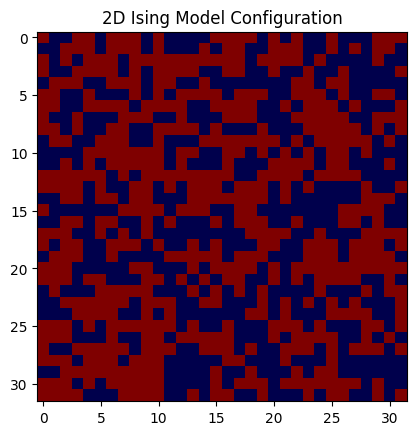

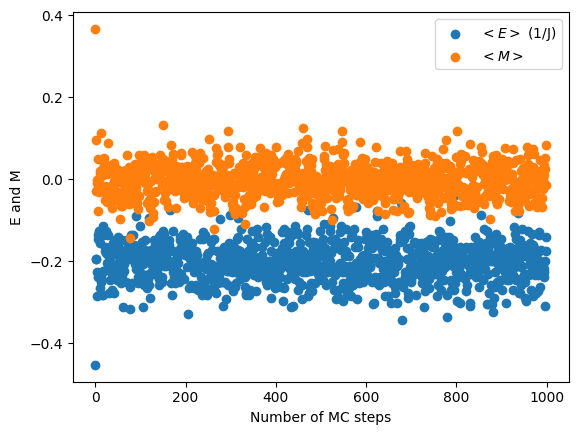

In [12]:
import matplotlib.pyplot as plt

model.plot_lattice()

steps = range(0,nsteps)
energies = simulation_data['average_energy']
magnetizations = simulation_data['average_magnetization']

plt.scatter(steps,energies,label='$<E>$ (1/J)') # J is the spin coupling coefficient, not Joule!
plt.scatter(steps,magnetizations,label='$<M>$')
plt.xlabel('Number of MC steps')
plt.ylabel('E and M')
plt.legend()
plt.show()

If you choose a high temperature, such as T = 10.0, due to entropic reasons, the spins are fluctuating such that the orientation of the spins is random and the mean magnetization is approximately zero. We are in the paramagnetic phase and have no domains.

# Task b)

For this task, you needed to do Monte-Carlo simulations at different constant temperatures and measure the mean magnetization per spin, the susceptibility, the internal energy, and the heat capacity after reaching equilibrium. Here, we have waited 2000 MC-steps. The results of our simulation agree quite well with the analytical solution of the spontaneous magnetization.
You can see that the magnetization is our order parameter here, which vanishes at $T = T_C = 2.269$. Note that the isothermal susceptibility and specifc heat are computed from the fluctuations of the magnetization and energy, respectively:

$$ \chi = \frac{<M^2> - <|M|>^2}{k_B T} $$
$$ C_V = \frac{<E^2> - <|E|>^2}{k_B T^2} $$

The temperature dependence of the order parameter m already gives us evidence of a phase transition. However, to examine if this transition is of first or second order, we need to look at the heat capacity. Since we find a discontinuity in the heat capacity, we know that the phase transition is of second order.

In [45]:
# === System-specific Parameters ===
L = 32 # Lattice length
J = 1 # Spin coupling coefficient
H = 0 # External magnetic field
initial_temperature = 0.5 # Temperature (units of kT/J)
final_temperature = 6
temperature_interval = 0.5
nsteps = 2000 # Number of Monte Carlo steps

In [46]:
data_start_index = int(nsteps/2)

data = {
    'temperatures':[],
    'energies':[],
    'magnetizations':[],
    'susceptibilities':[],
    'specific_heat':[]
    }

model = IsingModel2D(lattice_length=L,J=J,H=H)
for T in np.arange(initial_temperature,final_temperature,temperature_interval):
    simulation_data = model.run_monte_carlo_simulation(temperature=T,
                                                       number_of_steps=nsteps,
                                                       data_to_collect=['average_energy','average_magnetization'],
                                                       random=False, spin=1)
    data['temperatures'].append(T)
    data['energies'].append(simulation_data['average_energy'][-1])
    data['magnetizations'].append(simulation_data['average_magnetization'][-1])
    data['susceptibilities'].append(
        compute_susceptibility(
                            magnetizations=simulation_data['average_magnetization'][data_start_index:],
                            temperature=T,N=model.N)
                            )
    data['specific_heat'].append(
        compute_specific_heat(
                            energies=simulation_data['average_energy'][data_start_index:],
                            temperature=T,N=model.N)
                            )                   

In [47]:
import pandas as pd

df = pd.DataFrame(data)
df

,temperatures,energies,magnetizations,susceptibilities,specific_heat
0,0.5,-2.000000,1.000000,0.000000,0.000000
1,1.0,-2.000000,1.000000,0.001944,0.028566
2,1.5,-1.894531,0.970703,0.027985,0.305375
3,2.0,-1.789062,0.935547,0.312820,1.437229
4,2.5,-1.070312,0.035156,8.482040,2.075690
5,3.0,-0.660156,-0.044922,1.322013,1.292315
6,3.5,-0.621094,-0.058594,0.589462,0.827683
7,4.0,-0.507812,-0.023438,0.420282,0.725547
8,4.5,-0.488281,-0.021484,0.267896,0.587932
9,5.0,-0.437500,-0.029297,0.218419,0.497086


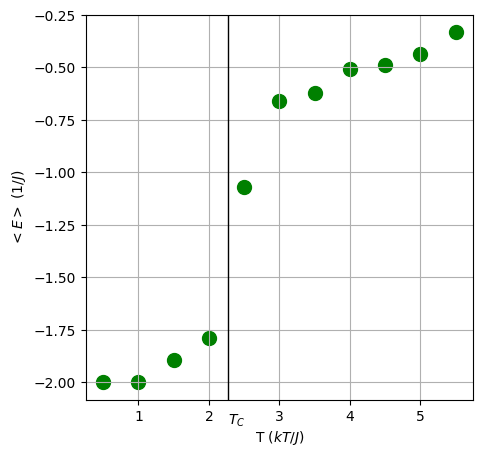

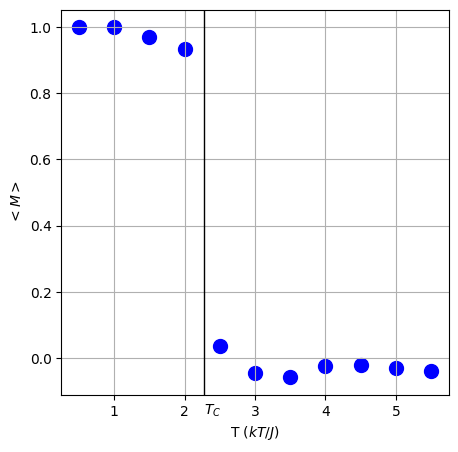

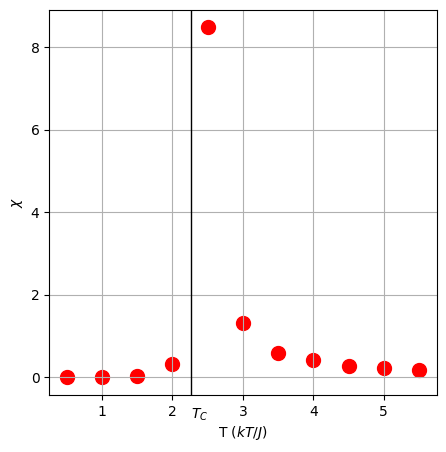

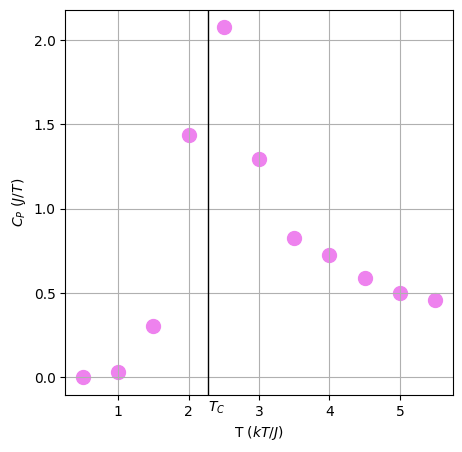

In [ ]:
TC = 2.269 # Analytical Curie temperature

df.plot(x='temperatures',y='energies',kind='scatter',figsize=(5,5),s=100,grid=True,xlabel='T ($kT/J$)',ylabel='$<E>$ ($1/J$)',color='green')
plt.axvline(x=TC, color='k', linestyle='-', linewidth=1) 
plt.text(x=TC,y=-2.2,s='$T_C$')
df.plot(x='temperatures',y='magnetizations',kind='scatter',figsize=(5,5),s=100,grid=True,xlabel='T ($kT/J$)',ylabel='$<M>$',color='blue')
plt.axvline(x=TC, color='k', linestyle='-', linewidth=1) 
plt.text(x=TC,y=-0.17,s='$T_C$')
df.plot(x='temperatures',y='susceptibilities',kind='scatter',figsize=(5,5),s=100,grid=True,xlabel='T ($kT/J$)',ylabel='$\chi$',color='red')
plt.axvline(x=TC, color='k', linestyle='-', linewidth=1) 
plt.text(x=TC,y=-1,s='$T_C$')
df.plot(x='temperatures',y='specific_heat',kind='scatter',figsize=(5,5),s=100,grid=True,xlabel='T ($kT/J$)',ylabel='$C_P$ ($J/T$)',color='violet')
plt.axvline(x=TC, color='k', linestyle='-', linewidth=1) 
plt.text(x=TC,y=-0.2,s='$T_C$');

# Task c)

Experimentally, it has been found that along the critical isotherm $ T = T_C$  a ferromagnet can be described by a critical exponent $\delta$ which characterizes the dependence of the spontaneous magnetization m ($<M>$) on the magnetic field $H$:
$$ m = DH^{1/ \delta} $$

To find $m$, we perform five canonical Monte-Carlo simulations at $T = T_C = 2.269$ , but this time with different external field values. From the $log(m)$ vs
$log(H)$ plot (see Figure 5), we can fit the slope $a = 1/\delta$. For the 2-dimensional Ising-model, it has been shown that for $ L → ∞ $ the critical exponent is $ \delta = 15 $. If your system is too small, then your fitted δ will deviate from that value.

In [131]:
# === System-specific Parameters ===
L = 100 # Lattice length
J = 1 # Spin coupling coefficient
magnetic_fields = [0.01,0.02,0.04,0.08,0.16] # External magnetic field H
temperature = 2.269 # Temperature (units of kT/J)
nsteps = 2000 # Number of Monte Carlo steps

In [132]:
magnetic_data = {
    'magnetic_fields':magnetic_fields,
    'magnetizations':[]
    }

for H in magnetic_fields:
    model = IsingModel2D(lattice_length=L,J=J,H=H)
    simulation_data = model.run_monte_carlo_simulation(temperature=temperature,
                                                    number_of_steps=nsteps,
                                                    data_to_collect=['average_magnetization'],
                                                    random=False, spin=1)
    magnetic_data[f'magnetizations'].append(simulation_data['average_magnetization'][-1])

In [133]:
df_magnetic = pd.DataFrame(magnetic_data)
df_magnetic

,magnetic_fields,magnetizations
0,0.01,0.7026
1,0.02,0.7720
2,0.04,0.7916
3,0.08,0.8382
4,0.16,0.8812


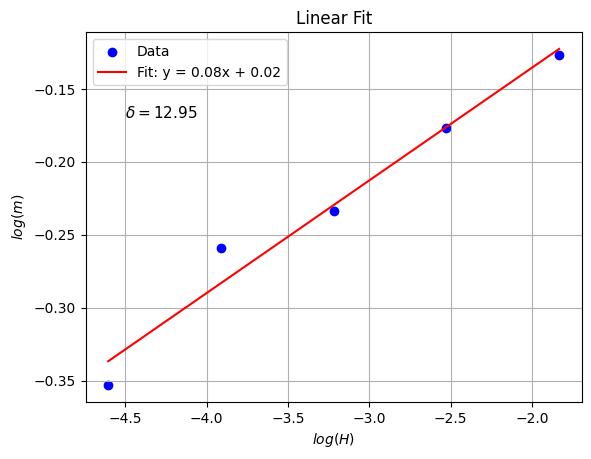

In [144]:
# Sample data
x = [np.log(H) for H in df_magnetic['magnetic_fields']]
y = [np.log(M) for M in df_magnetic['magnetizations']]
# Perform linear regression
slope, intercept = np.polyfit(x, y, 1)
delta = slope**-1

# Generate fitted line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Plot data and fit
plt.scatter(x, y, label="Data", color="blue")
plt.plot(x_fit, y_fit, label=f"Fit: y = {slope:.2f}x + {intercept:.2f}", color="red")
plt.text(-4.5,-0.17,s=f'$\delta = {delta:.2f}$',size=11)
plt.xlabel("$log(H)$")
plt.ylabel("$log(m)$")
plt.legend()
plt.title("Linear Fit")
plt.grid(True)
plt.show()
